# Paquetes y Funciones

In [1]:
import nbimporter
from funciones import *

# Avisos
import warnings
warnings.filterwarnings("ignore")

# SE HA AÑADIDO LOG(EXPERIENCIA) VOLVER A TUNEAR MODELOS

# 1. Carga datos:

### Rutas

In [2]:
ruta_actual = os.getcwd()

ruta_datos_procesados = ruta_actual.replace("Modelos", "Datos\\Procesados\\")
ruta_listas = ruta_actual + "\\listas\\"
ruta_encoders = ruta_actual + "\\encoders\\"

### Datos empleos

In [3]:
df_empleos = pd.read_csv(ruta_datos_procesados + 'datos_jobs_finales.csv')

In [4]:
df_empleos["categoria_empleo"] = df_empleos["categoria_empleo"].apply(lambda x: "machine learning engineer" if x == "machine learning" else x)

## -----------------------------------------------------------------------------------------------------------------------------

# 2. Prepocesamiento de datos

In [4]:
rutas = [ruta_listas, ruta_encoders]
encoders = [OneHotEncoder(), MultiLabelBinarizer()]

In [5]:
df_salario_min, df_salario_max = data_preparator(df_empleos, rutas, encoders)

## -----------------------------------------------------------------------------------------------------------------------------

# 3. Modelos de regresión

## 3.1. Preparación de datos

- ### Salario mínimo

In [6]:
X_min = df_salario_min.drop(["salario_min"], axis= 1)
y_min = df_salario_min[["salario_min"]]

- ### Salario máximo

In [7]:
X_max = df_salario_max.drop(["salario_max"], axis= 1)
y_max = df_salario_max[["salario_max"]]

## -----------------------------------------------------------------------------------------------------------------------------

## 3.2. Testeo de modelos

In [10]:
modelos = [LinearRegression(), RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), SVR(), KNeighborsRegressor(), DecisionTreeRegressor(), Ridge(), Lasso(), ElasticNet(), XGBRegressor(), LinearSVR()]

- ### Salario mínimo

In [11]:
MIN_SIN_PCA = model_tester(modelos, X_min, y_min)

In [12]:
MIN_SIN_PCA[MIN_SIN_PCA["mean_r2"] > 0.3].sort_values(by= "mean_r2", ascending= False)

,nombre,mean_r2,mean_MSE,mean_MAE
4,SVR,0.435862,0.053869,0.173324
3,GradientBoostingRegressor,0.424787,0.052174,0.173443
1,RandomForestRegressor,0.389427,0.057481,0.179264
10,XGBRegressor,0.370744,0.057595,0.175459
5,KNeighborsRegressor,0.346332,0.061191,0.188857
7,Ridge,0.334090,0.059116,0.184830
2,AdaBoostRegressor,0.322932,0.062198,0.194327


- ### Salario máximo

In [13]:
MAX_SIN_PCA = model_tester(modelos, X_max, y_max)

In [14]:
MAX_SIN_PCA[MAX_SIN_PCA["mean_r2"] > 0.3].sort_values(by= "mean_r2", ascending= False)

,nombre,mean_r2,mean_MSE,mean_MAE
4,SVR,0.467315,0.052025,0.174282
3,GradientBoostingRegressor,0.438649,0.052626,0.177284
1,RandomForestRegressor,0.411233,0.058074,0.180589
10,XGBRegressor,0.394015,0.057287,0.178659
2,AdaBoostRegressor,0.385294,0.060300,0.193858
5,KNeighborsRegressor,0.368606,0.062650,0.192500
7,Ridge,0.342929,0.062083,0.195904


## -----------------------------------------------------------------------------------------------------------------------------

### 3.2.1. TUNING SVR y GBR

In [16]:
params_SVR = {'kernel'      : ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree'      : [3, 4],
              'gamma'       : ['scale', 'auto'],
              'coef0'       : [-0.5, -0.4, -0.3],
              'C'           : [0.1, 0.2, 0.3],
              'epsilon'     : [0.01, 0.02],
              'shrinking'   : [True],
              'tol'         : [1e-6, 1e-5, 1e-7],
              'cache_size'  : [50, 100, 150],
              'verbose'     : [False],
              'max_iter'    : [550, 600, 650],
             }

params_GBR = {'loss'             : ["squared_error", "absolute_error", "huber", "quantile"],
              'n_estimators'     : [50, 100, 150],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'max_depth'        : [3, 5],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf' : [1, 2, 4],
              'subsample'        : [0.5, 0.7, 1.0],
              'max_features'     : [None, 'sqrt', 'log2']
              }

modelos = [SVR(), GradientBoostingRegressor()]
parametros = [params_SVR, params_GBR]

In [17]:
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(X_min, y_min, test_size = 0.2, random_state=42)

resultados_min = []

for modelo, params in zip(modelos, parametros):
    resultado = tunning(modelo, params, X_train_min, X_test_min, y_train_min, y_test_min, "min")
    resultados_min.append(resultado)
    
resultados_min = pd.concat([resultados_min[0], resultados_min[1]], axis= 0)
resultados_min.to_csv("resultados_tuning_min.csv", index= False, sep= ",")

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits
Fitting 5 folds for each of 5832 candidates, totalling 29160 fits


In [18]:
resultados_min

,Nombre,Modelo,Parametros,r2_score,MAE,MSE
0,SVR,"SVR(C=0.2, cache_size=50, coef0=-0.5, epsilon=...","{'C': 0.2, 'cache_size': 50, 'coef0': -0.5, 'd...",0.453050,0.171814,0.050199
0,GradientBoostingRegressor,([DecisionTreeRegressor(criterion='friedman_ms...,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",0.428094,0.177495,0.052489


In [26]:
resultados_min[resultados_min["Nombre"] == "SVR"]["Parametros"].values

array([{'C': 0.2, 'cache_size': 50, 'coef0': -0.5, 'degree': 3, 'epsilon': 0.02, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 600, 'shrinking': True, 'tol': 1e-06, 'verbose': False}],
      dtype=object)

In [19]:
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max, y_max, test_size = 0.2, random_state=42)

resultados_max = []

for modelo, params in zip(modelos, parametros):
    resultado = tunning(modelo, params, X_train_max, X_test_max, y_train_max, y_test_max, "max")
    resultados_max.append(resultado)
    
resultados_max = pd.concat([resultados_max[0], resultados_max[1]], axis= 0)
resultados_max.to_csv("resultados_tuning_max.csv", index= False, sep= ",")

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits
Fitting 5 folds for each of 5832 candidates, totalling 29160 fits


In [25]:
resultados_max

,Nombre,Modelo,Parametros,r2_score,MAE,MSE
0,SVR,"SVR(C=0.2, cache_size=50, coef0=-0.5, epsilon=...","{'C': 0.2, 'cache_size': 50, 'coef0': -0.5, 'd...",0.500332,0.178100,0.051543
0,GradientBoostingRegressor,([DecisionTreeRegressor(criterion='friedman_ms...,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",0.484759,0.179633,0.053149


In [24]:
resultados_max[resultados_max["Nombre"] == "SVR"]["Parametros"].values

array([{'C': 0.2, 'cache_size': 50, 'coef0': -0.5, 'degree': 3, 'epsilon': 0.02, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 600, 'shrinking': True, 'tol': 1e-06, 'verbose': False}],
      dtype=object)

## -----------------------------------------------------------------------------------------------------------------------------

### 3.2.2. Best SVR models

In [14]:
modelo_SVR = SVR()
params_SVR_min = {'kernel': ['rbf'],
                  'degree': [3],
                  'gamma': ['scale'],
                  'coef0': [-0.5],
                  'C': [0.2],
                  'epsilon': [i/100 for i in range(1,10)],
                  'shrinking': [True],
                  'tol': [1e-6],
                  'cache_size': [200],
                  'verbose': [False],
                  'max_iter': [i for i in range(500,710,10)],
                 }
    
params_SVR_max = {'kernel': ['rbf'],
                  'degree': [3],
                  'gamma': ['scale'],
                  'coef0': [-0.5],
                  'C': [0.2],
                  'epsilon': [i/100 for i in range(1,10)],
                  'shrinking': [True],
                  'tol': [1e-6],
                  'cache_size': [200],
                  'verbose': [False],
                  'max_iter': [i for i in range(500,710,10)],
                 }

X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(X_min, y_min, test_size = 0.2, random_state=42)
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max, y_max, test_size = 0.2, random_state=42)

In [15]:
df_resultados_tuning_min = tunning(modelo_SVR, params_SVR_min, X_train_min, X_test_min, y_train_min, y_test_min, "min", save= True)
df_resultados_tuning_max = tunning(modelo_SVR, params_SVR_max, X_train_max, X_test_max, y_train_max, y_test_max, "max", save= True)

Fitting 5 folds for each of 189 candidates, totalling 945 fits
Fitting 5 folds for each of 189 candidates, totalling 945 fits


In [16]:
df_resultados_tuning_min

,Nombre,Modelo,Parametros,r2_score,MAE,MSE
0,SVR,"SVR(C=0.2, coef0=-0.5, epsilon=0.06, max_iter=...","{'C': 0.2, 'cache_size': 200, 'coef0': -0.5, '...",0.455353,0.171879,0.049987


In [17]:
df_resultados_tuning_min["Parametros"].values

array([{'C': 0.2, 'cache_size': 200, 'coef0': -0.5, 'degree': 3, 'epsilon': 0.06, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 550, 'shrinking': True, 'tol': 1e-06, 'verbose': False}],
      dtype=object)

In [18]:
df_resultados_tuning_max

,Nombre,Modelo,Parametros,r2_score,MAE,MSE
0,SVR,"SVR(C=0.2, coef0=-0.5, epsilon=0.04, max_iter=...","{'C': 0.2, 'cache_size': 200, 'coef0': -0.5, '...",0.501798,0.178027,0.051392


In [19]:
df_resultados_tuning_max["Parametros"].values

array([{'C': 0.2, 'cache_size': 200, 'coef0': -0.5, 'degree': 3, 'epsilon': 0.04, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 500, 'shrinking': True, 'tol': 1e-06, 'verbose': False}],
      dtype=object)

## -----------------------------------------------------------------------------------------------------------------------------

## 3.3. PCA

Abrir los mejores modelos guardados y probar con PCA

In [20]:
modelo_svr_min = load('min_model.pkl')
modelo_svr_max = load('max_model.pkl')

In [21]:
salarios = ["min", "max"]
modelos_svr = [modelo_svr_min, modelo_svr_max]
X = [X_min, X_max]
y = [y_min, y_max]

In [22]:
df_resultados_PCA = pca_tester(salarios, modelos_svr, X, y)

In [23]:
df_resultados_PCA[df_resultados_PCA["salario"] == "min"].sort_values(by= "R2", ascending= False).head(1)

,salario,componentes,R2,MAE,MSE
25,min,128,0.463391,0.168424,0.04925


In [24]:
df_resultados_PCA[df_resultados_PCA["salario"] == "max"].sort_values(by= "R2", ascending= False).head(1)

,salario,componentes,R2,MAE,MSE
157,max,128,0.525775,0.169947,0.048918


### 3.3.1. TUNING SVR con PCA

In [25]:
pca_min = PCA(128, random_state=42)
pca_max = PCA(128, random_state=42)


X_min_pca = pca_min.fit_transform(X_min)
#with open("pca_min.pickle", 'wb') as archivo:
    #pickle.dump(pca_min, archivo)
        
X_max_pca = pca_max.fit_transform(X_max)
#with open("pca_max.pickle", 'wb') as archivo:
    #pickle.dump(pca_max, archivo)        

In [26]:
modelo_SVR = SVR()
params_SVR_min = {'kernel'      : ['linear', 'poly', 'rbf', 'sigmoid'],
                  'degree'      : [3, 4],
                  'gamma'       : ['scale', 'auto'],
                  'coef0'       : [-0.5, -0.4, -0.3],
                  'C'           : [0.1, 0.2, 0.3],
                  'epsilon'     : [i/100 for i in range(1,10)],
                  'shrinking'   : [True],
                  'tol'         : [1e-6, 1e-5, 1e-7],
                  'cache_size'  : [200],
                  'verbose'     : [False],
                  'max_iter'    : [550, 600, 650],
                 }
    
params_SVR_max = {'kernel'      : ['linear', 'poly', 'rbf', 'sigmoid'],
                  'degree'      : [3, 4],
                  'gamma'       : ['scale', 'auto'],
                  'coef0'       : [-0.5, -0.4, -0.3],
                  'C'           : [0.1, 0.2, 0.3],
                  'epsilon'     : [i/100 for i in range(1,10)],
                  'shrinking'   : [True],
                  'tol'         : [1e-6, 1e-5, 1e-7],
                  'cache_size'  : [200],
                  'verbose'     : [False],
                  'max_iter'    : [550, 600, 650],
                 }

X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(X_min_pca, y_min, test_size = 0.2, random_state=42)
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max_pca, y_max, test_size = 0.2, random_state=42)

In [28]:
df_resultados_tuning_min = tunning(modelo_SVR, params_SVR_min, X_train_min, X_test_min, y_train_min, y_test_min, "min")
df_resultados_tuning_max = tunning(modelo_SVR, params_SVR_max, X_train_max, X_test_max, y_train_max, y_test_max, "max")

Fitting 5 folds for each of 11664 candidates, totalling 58320 fits
Fitting 5 folds for each of 11664 candidates, totalling 58320 fits


In [29]:
df_resultados_tuning_min

,Nombre,Modelo,Parametros,r2_score,MAE,MSE
0,SVR,"SVR(C=0.2, coef0=-0.5, epsilon=0.02, max_iter=...","{'C': 0.2, 'cache_size': 200, 'coef0': -0.5, '...",0.463684,0.167731,0.049223


In [31]:
df_resultados_tuning_min["Parametros"].values

array([{'C': 0.2, 'cache_size': 200, 'coef0': -0.5, 'degree': 3, 'epsilon': 0.02, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 550, 'shrinking': True, 'tol': 1e-06, 'verbose': False}],
      dtype=object)

In [32]:
df_resultados_tuning_max

,Nombre,Modelo,Parametros,r2_score,MAE,MSE
0,SVR,"SVR(C=0.2, coef0=-0.5, epsilon=0.05, max_iter=...","{'C': 0.2, 'cache_size': 200, 'coef0': -0.5, '...",0.525975,0.169931,0.048898


In [33]:
df_resultados_tuning_max["Parametros"].values

array([{'C': 0.2, 'cache_size': 200, 'coef0': -0.5, 'degree': 3, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 600, 'shrinking': True, 'tol': 1e-06, 'verbose': False}],
      dtype=object)

## -----------------------------------------------------------------------------------------------------------------------------

In [35]:
modelo_SVR = SVR()
params_SVR_min = {'kernel': ['rbf'],
                  'degree': [3],
                  'gamma': ['scale'],
                  'coef0': [-0.5],
                  'C': [0.2],
                  'epsilon': [i/100 for i in range(1,10)],
                  'shrinking': [True],
                  'tol': [1e-6],
                  'cache_size': [200],
                  'verbose': [False],
                  'max_iter': [i for i in range(500,710,10)],
                 }
    
params_SVR_max = {'kernel': ['rbf'],
                  'degree': [3],
                  'gamma': ['scale'],
                  'coef0': [-0.5],
                  'C': [0.2],
                  'epsilon': [i/100 for i in range(1,10)],
                  'shrinking': [True],
                  'tol': [1e-6],
                  'cache_size': [200],
                  'verbose': [False],
                  'max_iter': [i for i in range(500,710,10)],
                 }

df_resultados_tuning_min = tunning(modelo_SVR, params_SVR_min, X_train_min, X_test_min, y_train_min, y_test_min, "min", save= True)
df_resultados_tuning_max = tunning(modelo_SVR, params_SVR_max, X_train_max, X_test_max, y_train_max, y_test_max, "max", save= True)
df_resultados = pd.concat([df_resultados_tuning_min, df_resultados_tuning_max], axis= 0)

Fitting 5 folds for each of 189 candidates, totalling 945 fits
Fitting 5 folds for each of 189 candidates, totalling 945 fits


In [39]:
df_resultados

,Nombre,Modelo,Parametros,r2_score,MAE,MSE
0,SVR,"SVR(C=0.2, coef0=-0.5, epsilon=0.02, max_iter=...","{'C': 0.2, 'cache_size': 200, 'coef0': -0.5, '...",0.463534,0.167824,0.049236
0,SVR,"SVR(C=0.2, coef0=-0.5, epsilon=0.05, max_iter=...","{'C': 0.2, 'cache_size': 200, 'coef0': -0.5, '...",0.526422,0.169887,0.048852


## -----------------------------------------------------------------------------------------------------------------------------

# Pruebo modelos con nuevos datos de entrada:

# Pipeline procesamiento de datos de entrada

    - Hago encoding columnas
    - Encoding herramientas
    - Transformación log
    - Limpio columnas   

- ### Datos de entrada:

In [19]:
herramientas = ["python", "sql", "ia"]
jornada = "jornada completa"
experiencia = 5
tipo_contrato = "indefinido"
beneficios = False
comunidad = "Galicia"
categoria_empleo = "data driven"

X_datos = {"herramientas": [herramientas],"jornada": [jornada],"experiencia": [experiencia],"tipo_contrato": [tipo_contrato],"beneficios": [beneficios],"comunidad": [comunidad],"categoria_empleo": [categoria_empleo]}

X = pd.DataFrame(X_datos)

In [20]:
X

,herramientas,jornada,experiencia,tipo_contrato,beneficios,comunidad,categoria_empleo
0,"[python, sql, ia]",jornada completa,5,indefinido,False,Galicia,data driven


- ### Transformo los datos de entrada:

In [21]:
X_testeo_min, X_testeo_max = data_transformer(X, ruta_encoders)

In [13]:
# Cargo modelos:
modelo_svr_min = load('min_model.pkl')
modelo_svr_max = load('max_model.pkl')

## - Predicción salario:

In [22]:
salario_minimo_predicho = np.exp(modelo_svr_min.predict(X_testeo_min))
salario_maximo_predicho = np.exp(modelo_svr_max.predict(X_testeo_max))
print(f"El rango salarial con estas características es de {round(int(salario_minimo_predicho), -2)} a {round(int(salario_maximo_predicho), -2)} € brutos anuales.")

El rango salarial con estas características es de 36400 a 41600 € brutos anuales.


## -----------------------------------------------------------------------------------------------------------------------------

## -----------------------------------------------------------------------------------------------------------------------------

# 4. Redes Neuronales

In [472]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN, Dense, LSTM, Embedding, Input
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.callbacks import ReduceLROnPlateau

In [307]:
# Escalado:
scaler = StandardScaler()
X_min_scaled = scaler.fit_transform(X_min)

In [642]:
X_min = X_min.values.astype(int)

In [643]:
X_train, X_test, y_train, y_test = train_test_split(X_min, y_min, test_size = 0.2, random_state=42)

In [644]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [645]:
# Model definition
np.random.seed(42)
model = Sequential()

model.add(Dense(units = 200, input_shape= (X_train.shape[1],), activation="linear"))  # Adjust input shape
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(units = 128))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(units = 64))
model.add(Activation("relu"))
model.add(Dropout(0.2))

# Hidden layers (optional, experiment with number and neurons)
##model.add(Dense(128, activation="relu"))
#model.add(Dense(64, activation="relu"))
#model.add(Dense(32, activation="relu"))

model.add(Dense(1, activation="linear"))  # Output layer for regression

# Model compilation
model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))  # Adjust loss and optimizer as needed

#model.summary()

In [646]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience= 5)

# Model training
history = model.fit(X_train,
                    y_train.values,
                    validation_data=(X_val, y_val.values),
                    epochs= 100,
                    #batch_size= 100,
                    callbacks=[early_stopping],
                    verbose = 1
)

# Model evaluation on test set
model.evaluate(X_test, y_test.values)

Epoch 1/100
22/22 [==============================] - 1s 9ms/step - loss: 61.4733 - val_loss: 5.3962
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 10.5281 - val_loss: 6.5306
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 5.5870 - val_loss: 2.1335
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 4.2049 - val_loss: 1.4136
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 3.2637 - val_loss: 1.0693
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 2.7416 - val_loss: 0.6402
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 2.4298 - val_loss: 0.7467
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 2.3262 - val_loss: 0.3773
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 2.2521 - val_loss: 0.3101
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 2.0882 - val_loss: 0.3828
Epoch 1

0.34529343247413635

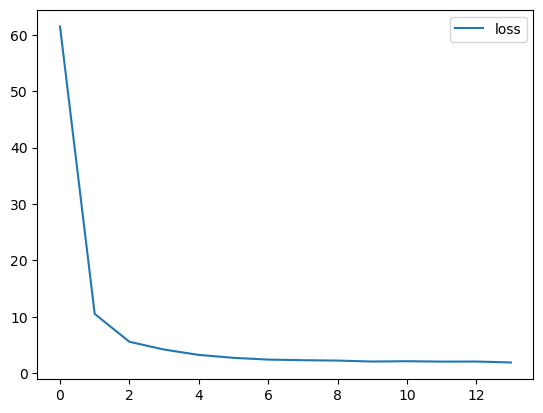

In [647]:
# loss
plt.plot(history.history["loss"], label = "loss")
plt.legend()
plt.show()

In [648]:
y_pred = model.predict(X_test)

7/7 [==============================] - 0s 1ms/step


In [649]:
r2_score_results = r2_score(y_test, y_pred)
mean_squared_error_results = mean_squared_error(y_test, y_pred)
mean_absolute_error_results = mean_absolute_error(y_test, y_pred)

In [650]:
print(r2_score_results)
print(mean_squared_error_results)
print(mean_absolute_error_results)

-2.762215262873278
0.34529359046991415
0.4713082304183239


In [17]:
import tensorflow as tf
from tensorflow.keras import Sequential


In [52]:
X = df_salario_max.drop(["salario_max"], axis= 1)
y = df_salario_max[["salario_max"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [53]:
def create_regression_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1) 
    ])

    model.compile(optimizer= "adam", loss='mean_squared_error')
    
    return model

imput_shape = X.shape[1]

regression_model = create_regression_model(imput_shape)

regression_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                5568      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9793 (38.25 KB)
Trainable params: 9793 (38.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = regression_model.fit(X_train.values.astype(int), y_train.values, epochs= 100)

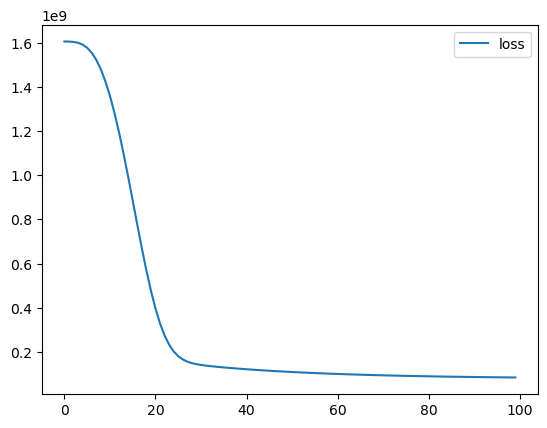

In [55]:
# loss
plt.plot(history.history["loss"], label = "loss")
plt.legend()
plt.show()

In [56]:
y_pred = regression_model.predict(X_test.values.astype(int))

7/7 [==============================] - 0s 1ms/step


In [58]:
r2_score_results = r2_score(y_test, y_pred)
mean_squared_error_results = mean_squared_error(y_test, y_pred)
mean_absolute_error_results = mean_absolute_error(y_test, y_pred)

In [59]:
print(r2_score_results)
print(mean_squared_error_results)
print(mean_absolute_error_results)

0.40049333194970516
94005198.67956196
7431.486504878394


In [38]:
# Para graficar:

modelo_gbr = GradientBoostingRegressor()
df_salario_max.columns = df_salario_max.columns.astype(str)
modelo_gbr.fit(X_train, y_train)
y_pred = modelo_gbr.predict(X_test)

In [39]:
test_y = y_test["salario_max"].values.flatten()

In [40]:
pred_y = y_pred.flatten()

<Axes: >

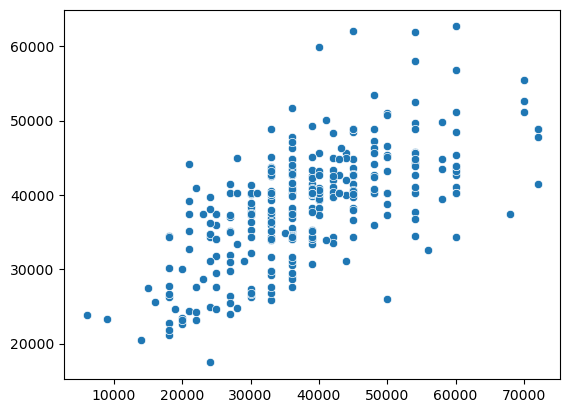

In [41]:
sns.scatterplot(x= test_y, y= pred_y)